# In this notebook, we are going to implement custom CNN model to analysis the data

# CNN V1 will use "Class weight" base on logarithm of the weights for the imbalance data

# CNN V2 will use over sampling (SMOTE) for the imbalance data

## https://en.wikipedia.org/wiki/Convolutional_neural_network


In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from PIL import Image


# load metadata.csv

In [2]:
df = pd.read_csv('input/HAM10000_metadata.csv', delimiter=',')
df.dataframeName = 'HAM10000_metadata.csv'

# preprocess labels

In [3]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(df['dx'])
print(list(label_encoder.classes_))
df['label'] = label_encoder.transform(df["dx"])
print(df.sample(5))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
195   HAM_0002327  ISIC_0033606  bkl      histo  60.0  female   
4418  HAM_0001850  ISIC_0030947   nv  follow_up  45.0    male   
263   HAM_0001837  ISIC_0033868  bkl      histo  80.0    male   
4575  HAM_0003111  ISIC_0030495   nv  follow_up  45.0  female   
1944  HAM_0000433  ISIC_0031554  mel      histo  55.0    male   

         localization  label  
195              neck      2  
4418  lower extremity      5  
263             trunk      2  
4575  lower extremity      5  
1944             back      4  


# features to label
akiex -> 0
bcc -> 1
bkl -> 2
df -> 3
mel -> 4
nv -> 5
vasc -> 6

In [4]:
features_dict = {0:"akiex",1:"bcc",2:"bkl",3:"df",
                 4:"mel",5:"nv",6:"vasc"}

labels = ['akiec','bcc','bkl','df','mel','nv','vasc']

# Calculate Class Weight

In [5]:
import math
total_data = 0
num_classes = 7
for num_of_data in df['label'].value_counts():
    total_data+=num_of_data
print("total number of data: ",total_data)
print(df['label'].value_counts())
#calc weight for each class
class_weight ={}
for index, value in df.label.value_counts().iteritems():
    v1 = math.log(total_data/(float(value)*num_classes))
    class_weight[index] = v1 if v1>1.0 else 1.0

for i in class_weight:
    print(i," ",class_weight[i])


total number of data:  10015
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64
5   1.0
4   1.0
2   1.0
1   1.0237058335894402
0   1.4759689281473518
6   2.310102041443345
3   2.520996970681355


# Preprocess image

In [6]:
from glob import glob
image_size = 32 #the size that the image will resize to
image_path = {os.path.splitext(os.path.basename(x))[0]: x
              for x in glob(os.path.join('input/','*','*.jpg'))}
#image path
df['path'] = df['image_id'].map(lambda id: image_path.get(id))

In [7]:
#image_64 is the actual image(resized to 64x64) store in the dataframe
#it takes time to process the image
df['image_64'] = df['path'].map(lambda path:Image.open(path).resize((image_size,image_size)))

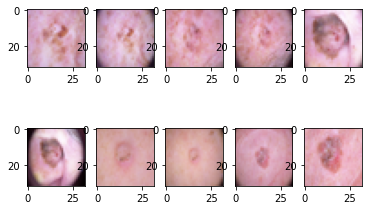

In [8]:
#print some image
index = 1
for image in df['image_64'].head(10):
    plots = plt.subplot(2,5,index)
    plots.imshow(image)
    index+=1

# Image to Array

In [9]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from sklearn.model_selection import StratifiedShuffleSplit,train_test_split

df['image'] = df['image_64'].map(lambda image: np.asarray(image))
data = np.asarray(df['image'].to_list())
#data = data.reshape(total_data,image_size*image_size*3).astype('float32')
data = data/255.0 #normalise the RGB value to [0...1]
label_to_one_hot = to_categorical(df['label'], num_classes=7)
#80% data for training
#20% data for testing
import random
train_data,test_data,train_label,test_label = train_test_split(data,label_to_one_hot,test_size=0.20,random_state=87,stratify=label_to_one_hot)

# Setup CNN model V1

In [10]:
from tensorflow.keras.layers import Dense, Dropout,Flatten,Conv2D,MaxPooling2D
num_classes = 7
dimension = image_size*image_size*3

model_CNN_V1 = Sequential()

#CNN layer 1:
model_CNN_V1.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu',padding='same'))
model_CNN_V1.add(Dropout(0.1))
model_CNN_V1.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 2
model_CNN_V1.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(Dropout(0.1))
model_CNN_V1.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 3
model_CNN_V1.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(Dropout(0.1))
model_CNN_V1.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V1.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer
model_CNN_V1.add(Flatten())

#hidden layer 1
model_CNN_V1.add(Dense(2048,activation='relu'))
model_CNN_V1.add(Dropout(0.2))

#hidden layer 2
model_CNN_V1.add(Dense(1024,activation='relu'))
model_CNN_V1.add(Dropout(0.2))

#output layer
model_CNN_V1.add(Dense(7,activation='softmax'))
model_CNN_V1.summary()

model_CNN_V1.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
dropout (Dropout)            (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)        3

# Train CNN V1

In [11]:
try:
    model_CNN_V1.load_weights('model/CNN_weight.h5')
except:
    print("new model_CNN_V1")

batch_size = 256
epochs = 200

train_history = model_CNN_V1.fit(
    train_data,train_label,
    epochs=epochs,
    validation_split=0.2,
    batch_size=batch_size,
    verbose=2,class_weight=class_weight)

new model_CNN_V1
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/200
26/26 - 5s - loss: 1.3589 - acc: 0.6528 - val_loss: 1.1761 - val_acc: 0.6569
Epoch 2/200
26/26 - 0s - loss: 1.1876 - acc: 0.6726 - val_loss: 1.0787 - val_acc: 0.6569
Epoch 3/200
26/26 - 0s - loss: 1.1410 - acc: 0.6726 - val_loss: 1.0098 - val_acc: 0.6569
Epoch 4/200
26/26 - 0s - loss: 1.0957 - acc: 0.6741 - val_loss: 1.0311 - val_acc: 0.6569
Epoch 5/200
26/26 - 0s - loss: 1.0781 - acc: 0.6772 - val_loss: 0.9939 - val_acc: 0.6538
Epoch 6/200
26/26 - 0s - loss: 1.0643 - acc: 0.6839 - val_loss: 0.9372 - val_acc: 0.6694
Epoch 7/200
26/26 - 0s - loss: 1.0081 - acc: 0.6859 - val_loss: 0.8925 - val_acc: 0.6669
Epoch 8/200
26/26 - 0s - loss: 0.9874 - acc: 0.6851 - val_loss: 0.9176 - val_acc: 0.6806
Epoch 9/200
26/26 - 0s - loss: 0.9801 - acc: 0.6850 - val_loss: 0.9130 - val_acc: 0.6762
Epoch 10/200
26/26 - 0s - loss: 0.9409 - acc

In [12]:
model_CNN_V1.save_weights('model/CNN_weight.h5')
model_CNN_V1.save('model/CNN_V1.h5')

# Applying Over Sampling

In [13]:
from imblearn.over_sampling import SMOTE
smote_sample = SMOTE(random_state=87)
train_data = train_data.reshape(-1,image_size*image_size*3)
train_data_oversample, train_label_oversample = smote_sample.fit_resample(train_data, train_label)
train_data_oversample = train_data_oversample.reshape(-1,image_size,image_size,3)
train_data = train_data.reshape(-1,image_size,image_size,3)

C:\Users\andre\anaconda3\envs\cmpt340_conda\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2 3 4 5 6] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


# Setup CNN Model V2

In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
num_classes = 7
dimension = image_size*image_size*3

model_CNN_V2 = Sequential()

#CNN layer 1:
model_CNN_V2.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(image_size,image_size,3),activation='relu',padding='same'))
model_CNN_V2.add(Dropout(0.2))
model_CNN_V2.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 2
model_CNN_V2.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(Dropout(0.2))
model_CNN_V2.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(MaxPooling2D(pool_size=(2,2)))

#CNN layer 3
model_CNN_V2.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(Dropout(0.2))
model_CNN_V2.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu',padding='same'))
model_CNN_V2.add(MaxPooling2D(pool_size=(2,2)))

#Flatten layer
model_CNN_V2.add(Flatten())
model_CNN_V2.add(Dropout(0.4))

#hidden layer 1
model_CNN_V2.add(Dense(2048,activation='relu'))
model_CNN_V2.add(Dropout(0.4))

#hidden layer 2
model_CNN_V2.add(Dense(1024,activation='relu'))
model_CNN_V2.add(Dropout(0.4))

#output layer
model_CNN_V2.add(Dense(7,activation='softmax'))
model_CNN_V2.summary()

model_CNN_V2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
dropout_5 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
dropout_6 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 16, 16, 64)       

# Train CNN V2

In [15]:
try:
    model_CNN_V2.load_weights('model/CNN_V2_weight.h5')
except:
    print("new model_CNN_V2")

# Train
batch_size = 256
epochs = 200

train_history_2 = model_CNN_V2.fit(
    train_data_oversample,train_label_oversample,
    epochs=epochs,
    batch_size= batch_size,
    validation_split=0.2,
    verbose=2,shuffle=True)

new model_CNN_V2
Epoch 1/200
118/118 - 2s - loss: 1.7469 - acc: 0.2230 - val_loss: 3.5960 - val_acc: 0.0059
Epoch 2/200
118/118 - 2s - loss: 1.4328 - acc: 0.3757 - val_loss: 3.7772 - val_acc: 0.1012
Epoch 3/200
118/118 - 2s - loss: 1.2334 - acc: 0.5019 - val_loss: 4.4782 - val_acc: 0.0936
Epoch 4/200
118/118 - 2s - loss: 1.0265 - acc: 0.6054 - val_loss: 4.4333 - val_acc: 0.1298
Epoch 5/200
118/118 - 2s - loss: 0.8018 - acc: 0.7028 - val_loss: 3.1145 - val_acc: 0.2100
Epoch 6/200
118/118 - 2s - loss: 0.6639 - acc: 0.7532 - val_loss: 3.0063 - val_acc: 0.2153
Epoch 7/200
118/118 - 2s - loss: 0.5440 - acc: 0.7973 - val_loss: 2.1700 - val_acc: 0.2718
Epoch 8/200
118/118 - 2s - loss: 0.4505 - acc: 0.8335 - val_loss: 1.5187 - val_acc: 0.5238
Epoch 9/200
118/118 - 2s - loss: 0.3904 - acc: 0.8544 - val_loss: 1.3178 - val_acc: 0.5827
Epoch 10/200
118/118 - 2s - loss: 0.3650 - acc: 0.8630 - val_loss: 1.3989 - val_acc: 0.5411
Epoch 11/200
118/118 - 2s - loss: 0.3118 - acc: 0.8835 - val_loss: 1.067

In [16]:
model_CNN_V2.save_weights('model/CNN_V2_weight.h5')
model_CNN_V2.save('model/CNN_V2.h5')

In [17]:
def plot_train_history(t_history, train,validation):
    plt.plot(t_history.history[train])
    plt.plot(t_history.history[validation])
    plt.title("train_history")
    plt.ylabel(train)
    plt.xlabel("epochs")
    plt.legend(['train','validation'],loc='upper left')
    plt.show()

# Train History

V1


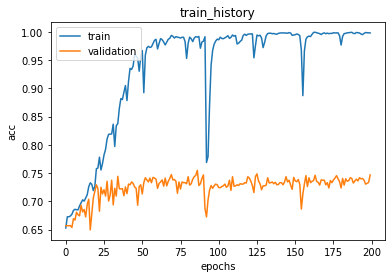

V2


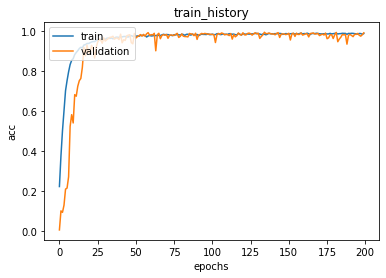

In [18]:
#plot train history
print("V1")
plot_train_history(train_history,'acc','val_acc')
print("V2")
plot_train_history(train_history_2,'acc','val_acc')

# Loss

V1


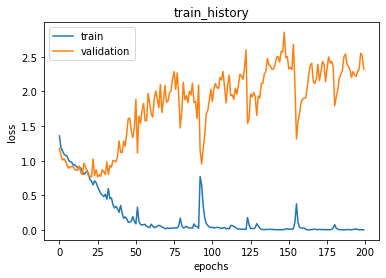

V2


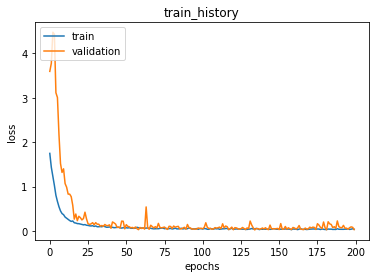

In [19]:
print("V1")
plot_train_history(train_history,'loss','val_loss')
print("V2")
plot_train_history(train_history_2,'loss','val_loss')

# Prediction score

In [20]:
#score
score = model_CNN_V1.evaluate(test_data, test_label)
print('Test accuracy for CNN V1:', score[1])

#score
score2 = model_CNN_V2.evaluate(test_data, test_label)
print('Test accuracy: for CNN V2', score2[1])

63/63 [==============================] - 3s 43ms/step - loss: 2.5008 - acc: 0.7294
Test accuracy for CNN V1: 0.7294058799743652
63/63 [==============================] - 0s 3ms/step - loss: 1.1161 - acc: 0.7439
Test accuracy: for CNN V2 0.7438841462135315


# Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
def print_confusion_matrix(model):
    score = model.evaluate(test_data, test_label)
    print('Test accuracy:', score[1])

    prediction = model.predict(test_data)
    prediction_class = np.argmax(prediction,axis=1)
    prediction_label = np.argmax(test_label,axis=1)

    mapping = lambda x:features_dict[x]
    pred_class_to_feature = np.array([mapping(x) for x in prediction_class])
    pred_label_to_feature = np.array([mapping(x) for x in prediction_label])
    matrix = confusion_matrix(pred_label_to_feature,pred_class_to_feature)
    matrix_display = ConfusionMatrixDisplay(matrix)
    fig,x = plt.subplots(figsize =(12,12))
    matrix_display.plot(ax=x)
    print(classification_report(pred_label_to_feature,pred_class_to_feature,target_names=labels))
    #print(pd.crosstab(pred_label_to_feature,pred_class_to_feature,colnames=['predicted']))

In [21]:
print("V1")
print_confusion_matrix(model_CNN_V1)
print("V2")
print_confusion_matrix(model_CNN_V2)

confusion matrix for CNN V1
predicted  akiex  bcc  bkl  df  mel    nv  vasc
actual                                         
akiex         23   11    6   5   10    10     0
bcc           10   40   10   2   10    26     5
bkl           10   14   82   3   32    79     0
df             2    5    0   8    0     7     1
mel            3    5   29   1   67   118     0
nv             2   14   41   1   55  1223     5
vasc           0    1    0   0    3     6    18
confusion matrix for CNN V2
predicted  akiex  bcc  bkl  df  mel    nv  vasc
actual                                         
akiex         27   13    8   1    7     9     0
bcc           13   51    8   3    7    19     2
bkl           12    8  100   3   35    62     0
df             2    9    2   6    1     3     0
mel            6    2   25   0   89   101     0
nv             4    8   55   4   69  1198     3
vasc           0    1    0   0    2     6    19
